In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import function as func
from scipy import special
import lmfit

In [2]:
def gause_model(x, mean, sigma, height):
    return height * np.exp( -1./2. * ((x-mean)/sigma) ** 2.)

def gause_residual(params, x, y, yerr):
    mean = params['mean']
    sigma = params['sigma']
    height = params['height']
    y_model = gause_model(x, mean, sigma, height)
    chi = (y - y_model)/yerr
    a = np.isfinite(chi)
    return chi[a]

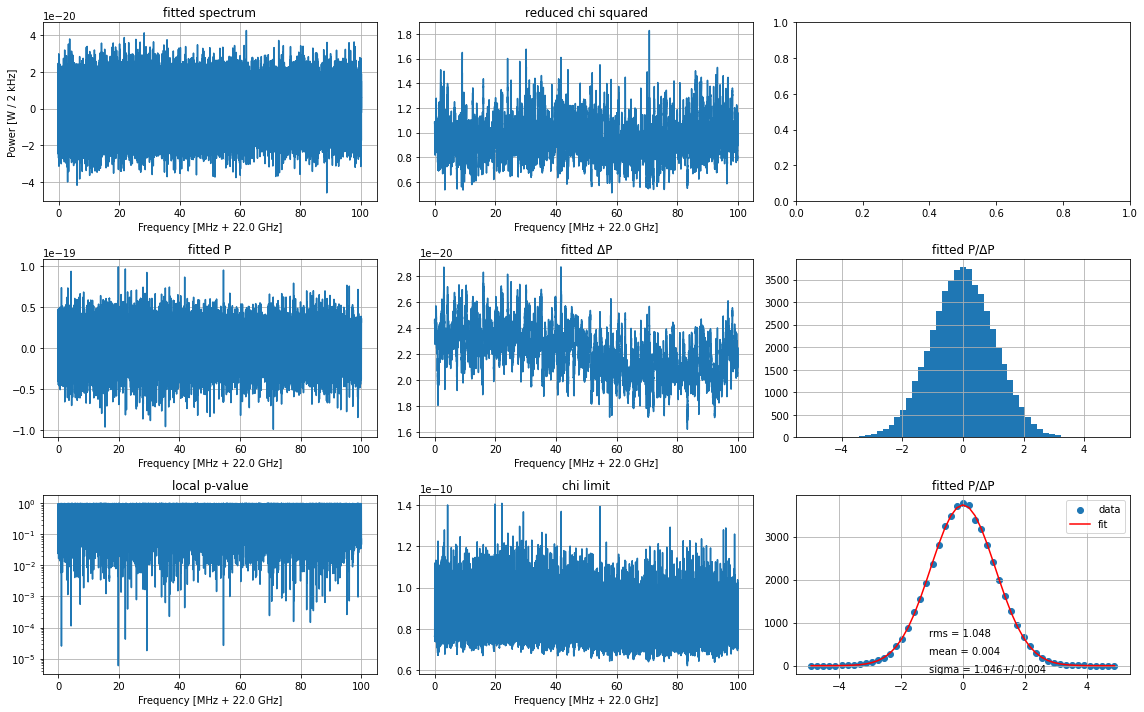

In [27]:
if __name__ == "__main__":
    for i in range(220, 221, 1):
        start_freq = i/10
        #print(start_freq)

        freq = np.array([])
        W_sub = np.array([])

        freq0 = np.array([])
        a = np.array([])
        b = np.array([])
        P = np.array([])
        a_err = np.array([])
        b_err = np.array([])
        P_err = np.array([])
        redchi = np.array([])
        success = []

        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)

        for i in range(initial, final, 2000):
            word = list(str(i))
            word.insert(2, ".")
            start = "".join(word)

            
            signal = func.csv_to_array("/data/ms2840a/result_data/signal_power/start_{}GHz.csv".format(start))
            _freq, _W_sub, _W_sub_err = func.rebin_func(signal["freq"], signal["W_sub"])
            freq = np.concatenate([freq, (_freq - start_freq*1e+9)/1e+6], 0)
            W_sub = np.concatenate([W_sub, _W_sub], 0)

            path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
            #path = "/data/ms2840a/result_data/null_sample_fit/start_{}GHz_40.csv".format(start)
            fit_result = func.csv_to_array(path)
            freq0 = np.concatenate([freq0, (fit_result["freq_0"] - start_freq*1e+9)/1e+6], 0)
            a = np.concatenate([a, fit_result["a"]], 0)
            b = np.concatenate([b, fit_result["b"]], 0)
            P = np.concatenate([P, fit_result["P"]], 0)
            a_err = np.concatenate([a_err, fit_result["a_err"]], 0)
            b_err = np.concatenate([b_err, fit_result["b_err"]], 0)
            P_err = np.concatenate([P_err, fit_result["P_err"]], 0)
            redchi = np.concatenate([redchi, fit_result["redchi"]], 0)
            success.append(fit_result["success"])


        fig, axes = plt.subplots(3,3,figsize=(16,10))

        ax = axes[0][0]
        ax.plot(freq, W_sub)
        ax.set_title("fitted spectrum")
        ax.set_xlabel("Frequency [MHz + {} GHz]".format(start_freq))
        ax.set_ylabel("Power [W / 2 kHz]")

        ax.grid()
        #ax.text(0.5, 0.01, "std: " + str(round(np.std(W_sub), 24)), transform=ax.transAxes)

        ax = axes[0][1]
        ax.plot(freq0, redchi)
        ax.set_title("reduced chi squared")
        ax.set_xlabel("Frequency [MHz + {} GHz]".format(start_freq))
        ax.set_ylabel("")
        ax.grid()

        ax = axes[1][0]
        ax.plot(freq0, P)
        ax.set_title("fitted P")
        ax.set_xlabel("Frequency [MHz + {} GHz]".format(start_freq))
        ax.set_ylabel("")
        ax.grid()
        #ax.text(0.5, 0.01, "std: " + str(round(np.std(P), 24)), transform=ax.transAxes)

        #p_err = np.ones(len(freq0))*1e-19
        ax = axes[1][1]
        ax.plot(freq0, P_err)
        ax.set_title("fitted ΔP")
        ax.set_xlabel("Frequency [MHz + {} GHz]".format(start_freq))
        ax.set_ylabel("")
        ax.grid()
        #ax.text(0.5, 0.01, "std: " + str(round(np.std(P_err), 24)), transform=ax.transAxes)
        #ax.text(0.5, 0.11, "mean: " + str(round(np.mean(P_err), 24)), transform=ax.transAxes)

        ax = axes[1][2]
        n, bins, hatches = ax.hist(P/P_err, bins=51, range=(-5,5))
        bins_x = np.zeros(len(n))
        for i in range(len(n)):
            bins_x[i] = (bins[i] + bins[i+1]) / 2
        ax.set_title("fitted P/ΔP")
        #ax.set_yscale("log")
        ax.grid()

        ax = axes[2][2]
        ax.scatter(bins_x, n, label="data")
        params = lmfit.Parameters()
        params.add('mean', value=0.)
        params.add('sigma', value=1.)
        params.add('height', value=1.)

        result = lmfit.minimize(gause_residual, params, args=(bins_x, n, np.sqrt(n)))
        height = result.params["height"].value
        mean = result.params["mean"].value
        sigma = result.params["sigma"].value
        sigma_err = result.params["sigma"].stderr
        ax.plot(bins_x, gause_model(bins_x, mean, sigma, height), label="fit", color="r")
        ax.set_title("fitted P/ΔP")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend()
        #ax.set_yscale("log")
        ax.grid()
        ax.text(0.4, 0.21, "rms = " + str(round(np.std(P/P_err), 3)), transform=ax.transAxes)
        ax.text(0.4, 0.11, "mean = " + str(round(mean, 3)), transform=ax.transAxes)
        ax.text(0.4, 0.01, "sigma = " + str(round(sigma, 3)) + "+/-" + str(round(sigma_err, 3)), transform=ax.transAxes)

        ax = axes[2][0]
        local_P = (1. - special.erf(P/P_err/math.pow(2., 1./2.)))/2.
        ax.plot(freq0, local_P)
        ax.set_title("local p-value")
        ax.set_xlabel("Frequency [MHz + {} GHz]".format(start_freq))
        ax.set_ylabel("")
        ax.set_yscale("log")
        ax.grid()

        ax = axes[2][1]
        A_eff = 14.e-4 # m^2
        C = 4.5e-14/np.power(10., -23./2.)*np.power(1./A_eff, 1./2.)
        P_max = np.array([max(val, 0) for val in P])
        P_gamma = P_max + 1.65*P_err
        chi = C*np.power(P_gamma, 1./2.)
        ax.plot(freq0, chi)
        ax.set_title("chi limit")
        ax.set_xlabel("Frequency [MHz + {} GHz]".format(start_freq))
        ax.grid()

        fig.tight_layout()
        #plt.savefig("../result_figure/fit_figure/start_{}GHz.pdf".format(str(start_freq)))
            
            

    